# Core

> Utils and extensions to `pydrake`.

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from simbox.imports import *

## Utils

In [ ]:
#| export
def viz_diagram(dgm, max_depth=1):
    "Visualize a `Diagram`."
    display(SVG(pydot.graph_from_dot_data(dgm.GetGraphvizString(max_depth=max_depth))[0].create_svg()))

In [ ]:
#| export
def set_sim_cfg(sim, cfg=dict(), verbose=False):
    "Set `Simulator`'s configuration."
    sim_cfg = ExtractSimulatorConfig(sim)
    for k,v in cfg.items():
        try:
            setattr(sim_cfg, k, v)
        except AttributeError:
            raise AttributeError(f"No such attribute '{k}'; check {[o.name for o in sim_cfg.__fields__]}")
    if verbose: print(f"Changed config:\n{sim_cfg}\n")
    ApplySimulatorConfig(sim_cfg, sim)
    if verbose: print(f"To:\n{ExtractSimulatorConfig(sim)}")

In [ ]:
#| export
def mk_log_diagram(sys, inp_idx: Union[int, str]=0, outp_idx: Union[int, str]=0, log_period: float=0.):
    "Returns a diagram with one (or zero) input port and one output port exported; a logger to that output port."
    builder = DiagramBuilder()
    builder.AddSystem(sys)
    if inp_idx is not None:
        inp = sys.get_input_port(inp_idx) if isinstance(inp_idx, int) else sys.GetInputPort(inp_idx)
        builder.ExportInput(inp)
    outp = sys.get_output_port(outp_idx) if isinstance(outp_idx, int) else sys.GetOutputPort(outp_idx)
    builder.ExportOutput(outp)
    
    logger = LogVectorOutput(outp, builder, log_period)
    return builder.Build(), logger

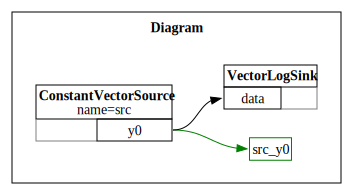

In [ ]:
#| hide
#| eval: false
sys = ConstantVectorSource([1,2])
sys.set_name('src')
dgm,logger = mk_log_diagram(sys, None, log_period=0.5)
viz_diagram(dgm)

In [ ]:
#| hide
#| eval: false
sim = Simulator(dgm)
sim.AdvanceTo(1)
log = logger.FindLog(sim.get_context())
log.sample_times(),log.data()

(array([0. , 0.5, 1. ]),
 array([[1., 1., 1.],
        [2., 2., 2.]]))

In [ ]:
#| export
class ParamsMixin():
    "Mixin to update parameters from their fields."
    named_params = namedview('params', ())
    _param_units = ()
    _numeric_params = BasicVector([])
    
    def _update_params(self):
        warnings.warn("Set custom values of parameters. Use only when initializing an instance.")
        params = self.named_params(self._numeric_params.get_mutable_value())
        units  = self.named_params(self._param_units)
        print('Press <space> <return> to skip. <q> <return> to skip to the end.')
        print('----------------------------------------------')
        for p,n in zip(params, params.get_fields()):
            print(f"Set value for {n+' ('+getattr(units, n)+')?':<20} current={p}", end=" ")
            pi = input()
            if pi == 'q': break
            if pi != ' ':
                try: setattr(params,n,float(pi))
                except ValueError: raise ValueError('Invalid input, must be a number.')
        print(f'\nDone!')

    @property
    def params(self):
        print(self.named_params(self._numeric_params.get_value()))

In [ ]:
#| export
def sample_ball(n_dim: int, r: float) -> np.ndarray:
    """
    Uniformly sample from a `n_dim`-hyperball with a radius `r`.
    """
    u = np.random.normal(0, 1, n_dim)
    norm = np.linalg.norm(u)
    r = np.random.rand()**(1.0 / n_dim) * r
    return r * u / norm

def sample_ellipsoid(n_dim: int, n_pt: int, A: np.ndarray=None, rho: float=1) -> np.ndarray:
    """
    Sample `n_pt` states from a `n-dim` ellipsoid defined by 
    a positive-definite matrix `A` and the squared radius `rho`.
    """
    if A is not None: assert np.shape(A)[0] == np.shape(A)[1] == n_dim
    zs = np.vstack([sample_ball(n_dim, np.sqrt(rho)) for _ in range(n_pt)])
    if A is None: return zs
    return zs @ np.linalg.inv(np.linalg.cholesky(A))

## System

In [ ]:
#| export
class Shift(LeafSystem):
    "Shift the input `u` by `y0`, i.e. `y = u + y0`."
    def __init__(self, y0: Union[np.ndarray, list[float]], name: str=''):
        super().__init__()
        self.set_name(name)
        self._y0 = np.asanyarray(y0)
        self.size = len(y0)
        self.DeclareVectorInputPort(name='u', size=self.size)
        self.DeclareVectorOutputPort(name='y=u+y0', size=self.size, calc=self.calc_outp)
    @property
    def y0(self):
        return self._y0
    @y0.setter
    def y0(self, val):
        assert len(val) == self.size, f"size must be {self.size}"
        self._y0 = np.asarray(val)
    def calc_outp(self, ctx, outp):
        inp = self.get_input_port(0).Eval(ctx)
        outp.SetFromVector(inp + self.y0)

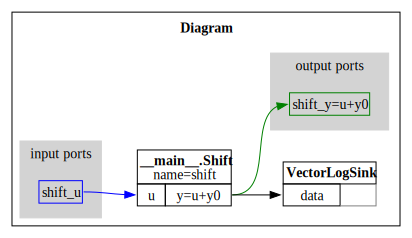

In [ ]:
#| hide
#| eval: false
dgm,logger = mk_log_diagram(Shift([1,2], 'shift'), log_period=0.2)
viz_diagram(dgm)

In [ ]:
#| hide
#| eval: false
ctx = dgm.CreateDefaultContext()
dgm.get_input_port().FixValue(ctx,[0,1])
sim = Simulator(dgm,ctx)
sim.AdvanceTo(1)
log = logger.FindLog(sim.get_context())
log.sample_times(),log.data()

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 array([[1., 1., 1., 1., 1., 1.],
        [3., 3., 3., 3., 3., 3.]]))

In [ ]:
#| export
class SimpleCSimBox():
    "A common place to store a `Diagram` built from a continuous `System`\
    with possible input shift and state output shift, a `Simulator`, a logger (`LogVectorOutput`)."
    def __init__(self,
                 sys,                         # Assume it has only one input port and one _state_ output port.
                 add_shift_inp: bool=False,   # True if there's a reference input.
                 add_shift_state: bool=False, # True if there's a reference state.
                 log_shift_inp: bool=False,   # Log the original (only valid when `inp_src` is provided) input or the shifted.
                 log_shift_state: bool=False, # Log the original state or the shifted.
                 log_period: float=0.,        # Frequency to log, per sec.
                 inp_src=None,                # Input source
                ):
        self.sys = sys
        self._register(add_shift_inp, add_shift_state, log_shift_inp, log_shift_state, log_period, inp_src)
        self._is_init = False

    def _register(self, add_shift_inp, add_shift_state, log_shift_inp, log_shift_state, log_period, inp_src):
        _sys = [self.sys]
        if add_shift_inp: self.shift_inp = Shift(np.zeros(self.sys.get_input_port().size()), 'shift_inp'); _sys.insert(0, self.shift_inp)
        if add_shift_state: self.shift_state = Shift(np.zeros(self.sys.get_output_port().size()), 'shift_state'); _sys.append(self.shift_state)
        # Builder: add systems
        builder = DiagramBuilder()
        for o in _sys: builder.AddSystem(o)
        for o,i in zip(_sys[:-1], _sys[1:]): builder.Connect(o.get_output_port(), i.get_input_port())
        if inp_src is not None:
            builder.AddSystem(inp_src)
            builder.Connect(inp_src.get_output_port(), _sys[0].get_input_port())
            builder.ExportOutput(_sys[-1].get_output_port())
        else:
            builder.ExportInput(_sys[0].get_input_port())
            builder.ExportOutput(_sys[-1].get_output_port())
        self._inp_src = inp_src
        # Loggers
        if (self._inp_src is not None) and (not log_shift_inp):
            _port = inp_src.get_output_port()
            self.inp_logger = LogVectorOutput(_port, builder, log_period)
        elif add_shift_inp and log_shift_inp:
            _port = _sys[0].get_output_port()
            self.inp_logger = LogVectorOutput(_port, builder, log_period)
        
        self.state_logger = LogVectorOutput(_sys[-1].get_output_port() if log_shift_state else self.sys.get_output_port(), builder, log_period)
        # Diagram
        self.dgm = builder.Build()
    
    def initialize(self, inp_val=None, state_val=None, ref_inp=None, ref_state=None, force_init=False):
        "Set reference input and state, if any. `FixValue` input port with `inp_val` if there is no `inp_src`."
        if self._is_init and not force_init: return
        # Set reference values
        if ref_inp is not None and hasattr(self, 'shift_inp'): self.shift_inp.y0 = ref_inp
        if ref_state is not None and hasattr(self, 'shift_state'): self.shift_state.y0 = -np.asarray(ref_state)
        # Set initial state, fix input port
        self.ctx = self.dgm.CreateDefaultContext()
        if (inp_val is not None) and (self._inp_src is None): self.get_inp().FixValue(self.ctx, inp_val)
        if state_val is not None: self.ctx.SetContinuousState(state_val)
        self.sim = Simulator(self.dgm, self.ctx)
        self._is_init = True
    
    def get_inp(self):
        return self.dgm.get_input_port()

    def get_outp(self):
        return self.dgm.get_output_port()
    
    def clear_log(self):
        self.inp_logger.FindMutableLog(self.sim.get_mutable_context()).Clear()
        self.state_logger.FindMutableLog(self.sim.get_mutable_context()).Clear()

    def get_inp_log_items(self):
        if hasattr(self, 'inp_logger'):
            log = self.inp_logger.FindLog(self.sim.get_context())
            return log.sample_times(), log.data()
        return

    def get_state_log_items(self):
        log = self.state_logger.FindLog(self.sim.get_context())
        return log.sample_times(), log.data()

    def extract_dyn(self):
        "Returns the (callable) dynamical equation `xdot = f(t,x,u)` \
        where `u` is the (possibly) shifted control input, `x` is the original state."
        assert hasattr(self, 'ctx'), "Initialize first to create a default context `ctx`."
        assert self._inp_src is None, "Expect the system has no `inp_src`."
        ctx = self.ctx.Clone()
        def _f(t,x,u):
            ctx.SetContinuousState(x)
            self.dgm.get_input_port(0).FixValue(ctx, u)
            return self.dgm.EvalTimeDerivatives(ctx).get_vector().CopyToVector()
        return _f

    def plot_log(self, ax=None, figsize=(2,2), labels=None):
        if ax is None: fig,ax = plt.subplots(figsize=figsize)
        ts, vals = self.get_state_log_items()
        if labels is not None: assert len(labels) == len(vals)
        else: labels = [f'y[{i}]' for i in range(len(vals))]
        colors = plt.get_cmap('rainbow')(np.linspace(0,1,len(vals)))
        for i,val in enumerate(vals):
            ax.plot(ts, val, 'x-', c=colors[i], label=labels[i])
        ax.set_xlabel('t (sec)')
        ax.legend(loc=1)
                            

In [ ]:
show_doc(SimpleCSimBox.initialize)

---

[source](https://github.com/ts-flake/chemsim/blob/main/chemsim/core.py#L152){target="_blank" style="float:right; font-size:smaller"}

### SimpleCSimBox.initialize

>      SimpleCSimBox.initialize (inp_val=None, state_val=None, ref_inp=None,
>                                ref_state=None, force_init=False)

Set reference input and state, if any. `FixValue` input port with `inp_val` if there is no `inp_src`.

In [ ]:
show_doc(SimpleCSimBox.extract_dyn)

---

[source](https://github.com/ts-flake/chemsim/blob/main/chemsim/core.py#L185){target="_blank" style="float:right; font-size:smaller"}

### SimpleCSimBox.extract_dyn

>      SimpleCSimBox.extract_dyn ()

Returns the (callable) dynamical equation `xdot = f(t,x,u)`         where `u` is the (possibly) shifted control input, `x` is the original state.

In [ ]:
# xdot = x - u
#    y = x
sys = AffineSystem(A=np.eye(2), B=-np.eye(2), C=np.eye(2)); sys.set_name('aff')
tst = SimpleCSimBox(sys, True, True, True, True, 0.2)

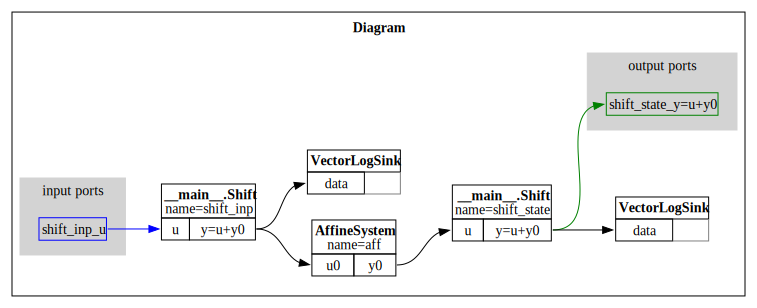

In [ ]:
#| eval: false
viz_diagram(tst.dgm)

In [ ]:
tst.initialize([0,0], [1,1], ref_inp=[0,1], ref_state=[-1,0], force_init=True)

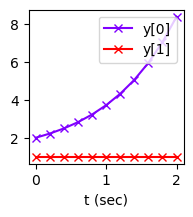

In [ ]:
# tst.clear_log()
tst.sim.AdvanceTo(2)
tst.plot_log()

## Source

In [ ]:
#| export
class BoxRandomSource(LeafSystem):
    "Uniform random source with box-contraints."
    def __init__(self, n_dim, ub, lb, sampling_period=1., seed=None):
        super().__init__()
        assert len(ub) == len(lb) == n_dim
        self.set_name('random_src')
        # Uniform sampler
        rng = np.random.default_rng(seed)
        self.sampler = (lambda o=None: rng.random(n_dim) * np.subtract(ub, lb) + lb)
        # Random discrete state
        rs = self.DeclareDiscreteState(n_dim) 
        self.DeclareStateOutputPort('random_state', rs)
        self.DeclarePeriodicDiscreteUpdateEvent(period_sec=sampling_period, offset_sec=sampling_period, update=self.update)
        self.DeclareInitializationDiscreteUpdateEvent(update=self.init_update)

    def update(self, ctx, outp):
        outp.get_mutable_vector(0).set_value(self.sampler())

    def init_update(self, ctx, outp):
        outp.get_mutable_vector(0).set_value(self.sampler())

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()